In [2]:
from time import time

import torch
import sklearn.datasets
import sklearn.preprocessing
import sklearn.model_selection
import numpy as np
import math
import matplotlib.pyplot as plt

from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST as FMNIST
from torchvision.datasets import EMNIST
import torchvision.transforms as transforms

import Onlinehd

SEED = 1234
device = 'cuda' if torch.cuda.is_available() else 'cpu'
np.random.seed(SEED)
torch.manual_seed(SEED)

### Load Function MNIST(Digits), FMNIST, EMNIST(Letters)

In [4]:
def load():
    download_root = 'data/emnist_dataset'
    
    temp = EMNIST(download_root, split = 'letters', train=True, download=True)
    x = temp.data.unsqueeze(3).numpy().transpose((0,2,1,3))
    y = temp.targets.numpy() - 1
    temp = EMNIST(download_root, split='letters', train=False, download=True)
    x_test = temp.data.unsqueeze(3).numpy().transpose((0,2,1,3))
    y_test = temp.targets.numpy() - 1
    
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).long()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).long()
    
    x_test = x_test.float()
    y_test = y_test.long().squeeze()

    if len(x.shape) != 3:
        x = x.squeeze(3)
        x_test = x_test.squeeze(3)
    
    return x, x_test, y, y_test

# EMNIST

In [5]:
e_x, e_x_test, e_y, e_y_test = load()

/Users/jeongseongheon/opt/anaconda3/envs/UCI/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
e_x = e_x.reshape(-1, 784)
e_x_test = e_x_test.reshape(-1, 784)

e_scaler = sklearn.preprocessing.Normalizer().fit(e_x.reshape(-1, 784))
e_x = torch.tensor(e_scaler.transform(e_x.reshape(-1, 784)))
e_x_test = torch.tensor(e_scaler.transform(e_x_test.reshape(-1, 784)))

In [7]:
from time import time

e_classes = e_y.unique().size(0)
e_features = e_x.size(1)
Emodel = Onlinehd.OnlineHD(e_classes, e_features, dim=10000)

if torch.cuda.is_available():
    e_x = e_x.cuda()
    e_y = e_y.cuda()
    e_x_test = e_x_test.cuda()
    e_y_test = e_y_test.cuda()
    Emodel = Emodel.to('cuda')
    print('Using GPU!')

print('Training...')
t = time()
Emodel = Emodel.fit(e_x, e_y, bootstrap=1.0, lr=0.035, epochs=20)
t = time() - t

Training...
0
10


In [8]:
print('Validating...')
e_yhat = Emodel(e_x)
e_yhat_test = Emodel(e_x_test)

e_acc = (e_y == e_yhat).float().mean()
e_acc_test = (e_y_test == e_yhat_test).float().mean()

print(f'{e_acc = :6f}')
print(f'{e_acc_test = :6f}')
print(f'{t = :6f}')

Validating...
e_acc = 0.860625
e_acc_test = 0.832452
t = 89.408315


In [9]:
def fgsm_attack(x_original, epsilon, gradient):
    # Get Gradient sign
    grad_sign = gradient.sign()
    # Add epsilon*grad_sign perturbation to the original input
    perturbation = epsilon*grad_sign
    x_perturbed = x_original + perturbation
    return x_perturbed, perturbation

In [10]:
import torch.nn as nn
import time

epsilons = torch.Tensor([0.01, 0.03, 0.07, 0.1])
acc_results_non = dict()
verbose = False
criterion = nn.CosineEmbeddingLoss()
N_VAL_SAMPLES = e_x_test.data.shape[0]

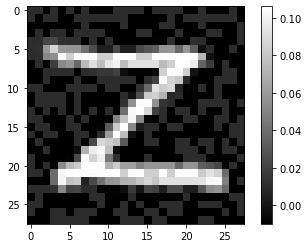


FGSM Attack with epsilon = 0.01000 | Elapsed time: 206.15 seconds.
Accuracy: Before the attack -> 83.24%	|	After the attack -> 79.75%


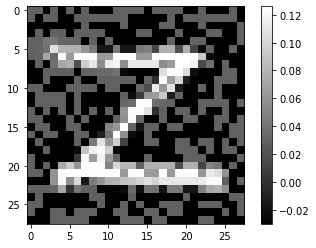


FGSM Attack with epsilon = 0.03000 | Elapsed time: 193.79 seconds.
Accuracy: Before the attack -> 83.24%	|	After the attack -> 18.83%


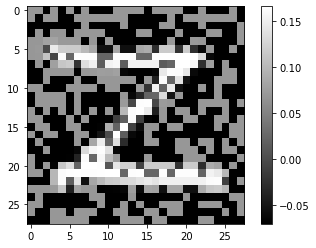


FGSM Attack with epsilon = 0.07000 | Elapsed time: 197.90 seconds.
Accuracy: Before the attack -> 83.24%	|	After the attack -> 3.77%


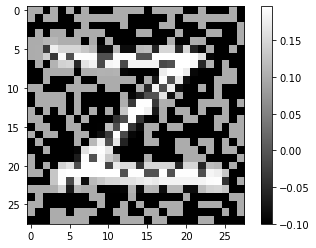


FGSM Attack with epsilon = 0.10000 | Elapsed time: 192.80 seconds.
Accuracy: Before the attack -> 83.24%	|	After the attack -> 4.00%


In [15]:
attack_sample = {'0.01':torch.zeros(20800, 28, 28),
                 '0.03':torch.zeros(20800, 28, 28),
                 '0.07':torch.zeros(20800, 28, 28),
                 '0.1':torch.zeros(20800, 28, 28)}

for eps in epsilons:
    correct_unperturbed = 0
    correct_perturbed = 0
    t0 = time.perf_counter()

    attack = torch.zeros(20800, 28, 28)
    labels = torch.zeros(20800)
    
    for j in range(len(e_x_test)):
    ### NOTE: IT WOULD BE MORE EFFICIENT TO ITERATE ONLY ONCE THROUGH THE DATA AND PERFORM ALL THE ATTACKS
        x_origin, y_target = e_x_test[j], e_y_test[j]
        x_origin, y_target = x_origin.to(device), y_target.to(device)
        x_origin.requires_grad = True

        y_pred = Emodel(x_origin.reshape(-1, 784))
        
        if y_pred == y_target:#Only make attack on correctly classified samples
            correct_unperturbed += 1
            
        label = torch.ones(e_classes, dtype=int) * -1
        label[y_target.item()] = 1
        # Calculate loss and gradient
        output = Emodel.encode(x_origin.reshape(-1, 784))
        loss = criterion(output, Emodel.model, label)
        grad = torch.autograd.grad(outputs=loss, inputs=x_origin)[0]

        perturbed_x, _ = fgsm_attack(x_origin, epsilon=eps, gradient=grad)
        perturbed_output = Emodel(perturbed_x.reshape(-1, 784))            

        if perturbed_output == y_target:
            correct_perturbed += 1
        
        attack[j] = perturbed_x.reshape(28, 28)
        labels[j] = y_target
        
    if eps == 0.1:
        attack_sample['0.1'] = attack
    elif eps == 0.07:
        attack_sample['0.07'] = attack
    elif eps == 0.03:
        attack_sample['0.03'] = attack
    else:
        attack_sample['0.01'] = attack           
        
    plt.imshow(perturbed_x.detach().numpy().reshape(28, 28), cmap='gray')
    plt.colorbar()
    plt.show()
    acc_before_attack = correct_unperturbed / N_VAL_SAMPLES
    acc_after_attack = correct_perturbed / N_VAL_SAMPLES
    print(f'\nFGSM Attack with epsilon = {eps:.5f} | Elapsed time: {time.perf_counter() - t0:.2f} seconds.')
    print(f'Accuracy: Before the attack -> {100 * acc_before_attack:.2f}%\t|\tAfter the attack -> {100 * acc_after_attack:.2f}%')
    acc_results_non[eps.item()] = acc_after_attack
acc_results_non[0] = acc_before_attack

In [16]:
import pickle 

data = {'data' : attack_sample,
        'label' : labels}

with open('EMNIST_FGSM_HD.pickle', 'wb') as f:
    pickle.dump(data, f)

In [17]:
for eps in attack_sample.keys():
    attack_norm = attack_sample[eps].detach().numpy().reshape(-1, 784)
    attack_norm = e_scaler.transform(attack_norm)
    attack_sample[eps] = torch.from_numpy(attack_norm).float()

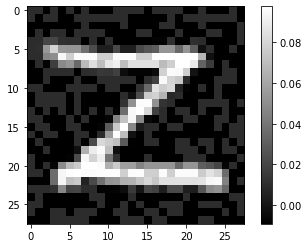

In [18]:
plt.imshow(attack_sample['0.01'][-1].reshape(28, 28), cmap='gray')
plt.colorbar()

In [19]:
print('Validating...')
yhat = Emodel(e_x)
yhat_test = Emodel(e_x_test)
yhat_attack_001 = Emodel(attack_sample['0.01'])
yhat_attack_003 = Emodel(attack_sample['0.03'])
yhat_attack_007 = Emodel(attack_sample['0.07'])
yhat_attack_010 = Emodel(attack_sample['0.1'])

acc = (e_y == yhat).float().mean()
acc_test = (e_y_test == yhat_test).float().mean()
acc_attack_001 = (labels == yhat_attack_001).float().mean()
acc_attack_003 = (labels == yhat_attack_003).float().mean()
acc_attack_007 = (labels == yhat_attack_007).float().mean()
acc_attack_010 = (labels == yhat_attack_010).float().mean()

print(f'{acc = :6f}')
print(f'{acc_test = :6f}')
print(f'{acc_attack_001 = :6f}')
print(f'{acc_attack_003 = :6f}')
print(f'{acc_attack_007 = :6f}')
print(f'{acc_attack_010 = :6f}')

Validating...
acc = 0.860625
acc_test = 0.832452
acc_attack_001 = 0.809375
acc_attack_003 = 0.636010
acc_attack_007 = 0.222740
acc_attack_010 = 0.138654
